In [1]:
import os
import pathlib
import numpy as np
import imageio
import glob
import matplotlib.pyplot as plt
import IPython.display
import PIL.Image
import imageio
import cv2
import scipy.ndimage as nd

## Input Images Path

In [2]:
# Relative paths to the notebook
images_path = glob.glob("images/*.pgm")

output_path = 'outputs/'
# If output folder does not exist, create it
p = pathlib.Path(output_path)
if not p.is_dir():
    p.mkdir()

# Execute all dithering functions to all images
# NOTE: THE ENTIRE ACQUISITION TAKES ABOUT 5 MINUTES
execute_acquisitions = True

In [3]:
images = {}
for img in images_path:
     images[os.path.split(img)[1]] = cv2.imread(img,-1)

## Filters and Limiar Methods

In [4]:
def maximum_filter(input_image, window_size):
    return nd.maximum_filter(input_image, size=(window_size, window_size))


def minimum_filter(input_image, window_size):
    return nd.minimum_filter(input_image, size=(window_size, window_size))


def mean_filter(input_image, window_size):
    return nd.uniform_filter(input_image, size=(window_size, window_size))


def median_filter(input_image, window_size):
    return nd.median_filter(input_image, size=(window_size, window_size))


def std_filter(input_image, window_size):
    return nd.generic_filter(input_image, np.std, size=(window_size, window_size))


def global_limiar(input_image, threshold):
    return np.where(input_image > threshold, 0, 255).astype(np.uint8)
    

def bernsen_limiar(input_image, window_size):
    maximum = maximum_filter(input_image, window_size).astype(np.int32)
    minimum = minimum_filter(input_image, window_size).astype(np.int32)
    
    limiar = maximum/2 + minimum/2
    
    return np.where(input_image > limiar, 0, 255).astype(np.uint8)


def niblack_limiar(input_image, window_size, k):
    mean = mean_filter(input_image, window_size).astype(np.int32)
    std = std_filter(input_image, window_size).astype(np.int32)
    
    limiar = mean + std * k
    
    return np.where(input_image > limiar, 0, 255).astype(np.uint8)


def sauvola_limiar(input_image, window_size, k, R):
    mean = mean_filter(input_image, window_size).astype(np.int32)
    std = std_filter(input_image, window_size).astype(np.int32)
    
    limiar = mean * (1 + k * (std/R - 1))
    
    return np.where(input_image > limiar, 0, 255).astype(np.uint8)


def phansalskar_limiar(input_image, window_size, k, R, p, q):
    mean = mean_filter(input_image, window_size).astype(np.int32)
    std = std_filter(input_image, window_size).astype(np.int32)
    
    limiar = mean * (1 + p*np.exp(-1*q*mean) + k * (std/R - 1))
    
    return np.where(input_image > limiar, 0, 255).astype(np.uint8)


def contrast_limiar(input_image, window_size):
    pass


def mean_limiar(input_image, window_size):
    limiar = mean_filter(input_image, window_size)
    
    return np.where(input_image > limiar, 0, 255).astype(np.uint8)


def median_limiar(input_image, window_size):
    limiar = median_filter(input_image, window_size)
    
    return np.where(input_image > limiar, 0, 255).astype(np.uint8)

## Execution

In [5]:
output_images = {}

In [12]:
# The following methods DO NOT USE the standard deviation of the image, and therefore they run fast
if execute_acquisitions:
    # For every image do global limiarization with thresholds 64, 128 and 192
    for image_name, image in images.items():
        image_name = image_name[:-3] + 'png'
        
        global_limiar_64 = global_limiar(image, 64)
        global_limiar_128 = global_limiar(image, 128)
        global_limiar_192 = global_limiar(image, 192)

        # Write the images in file
        imageio.imwrite(output_path + 'global_64' + image_name, global_limiar_64)
        imageio.imwrite(output_path + 'global_128' + image_name, global_limiar_128)
        imageio.imwrite(output_path + 'global_192' + image_name, global_limiar_192)
        
        # Add images to output dict for further analyses
        output_images['global_64' + image_name] = global_limiar_64
        output_images['global_128' + image_name] = global_limiar_128
        output_images['global_192' + image_name] = global_limiar_192
    
    # For every image do mean, median and bernsen limiarization for window size 5, 9, 15
    for image_name, image in images.items():
        image_name = image_name[:-3] + 'png'
        
        for window_size in [5, 9, 15]:
            mean = mean_limiar(image, window_size)
            median = global_limiar(image, window_size)
            bernsen = bernsen_limiar(image, window_size)

            # Write the images in file
            imageio.imwrite(output_path + 'mean_' + str(window_size) + image_name, mean)
            imageio.imwrite(output_path + 'median_' + str(window_size) + image_name, median)
            imageio.imwrite(output_path + 'bernsen_' + str(window_size) + image_name, bernsen)
            
            # Add images to output dict for further analyses
            output_images['mean_' + str(window_size) + image_name] = mean
            output_images['median_' + str(window_size) + image_name] = median
            output_images['bernsen_' + str(window_size) + image_name] = bernsen

In [7]:
import time

In [14]:
t1 = time.time()
# The following methods USE the standard deviation of the image, and therefore they run slow
if execute_acquisitions:    
    # For every image do niblack, sauvola and phansalskar limiarization for window size 3, 5, 9, 15
    # k, R, p, q parameters are used with the suggested values
    for image_name, image in images.items():
        image_name = image_name[:-3] + 'png'
        
        for window_size in [3, 5, 9, 15]:
            niblack = niblack_limiar(image, window_size, 0.5)
            sauvola = sauvola_limiar(image, window_size, 0.5, 128)
            phansalskar = phansalskar_limiar(image, window_size, 0.25, 0.5, 2, 10)

            # Write the images
            imageio.imwrite(output_path + 'niblack_' + str(window_size) + image_name, niblack)
            imageio.imwrite(output_path + 'sauvola_' + str(window_size) + image_name, sauvola)
            imageio.imwrite(output_path + 'phansalskar_' + str(window_size) + image_name, phansalskar)
            
            # Add images to output dict for further analyses
            output_images['niblack_' + str(window_size) + image_name] = niblack
            output_images['sauvola_' + str(window_size) + image_name] = sauvola
            output_images['phansalskar_' + str(window_size) + image_name] = phansalskar

print('TOTAL TIME:', time.time() - t1)

TOTAL TIME: 453.3580210208893


## Analysis

### Global Limiarization

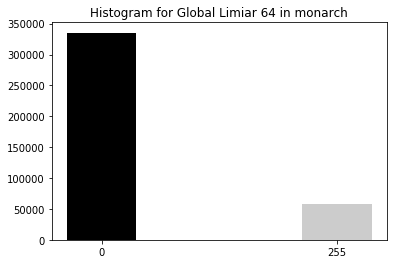

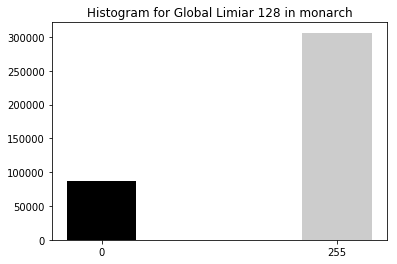

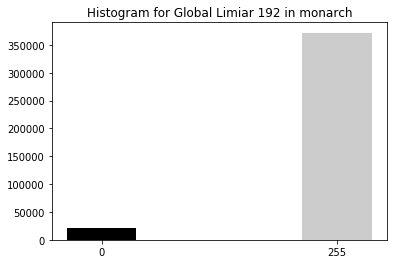

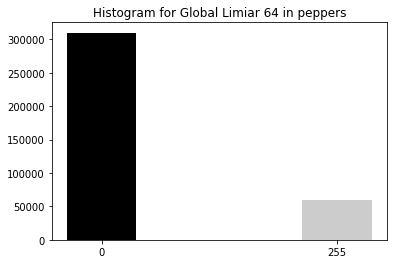

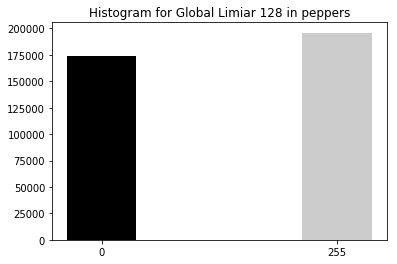

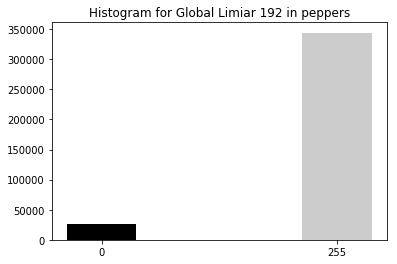

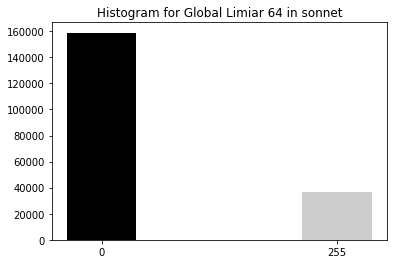

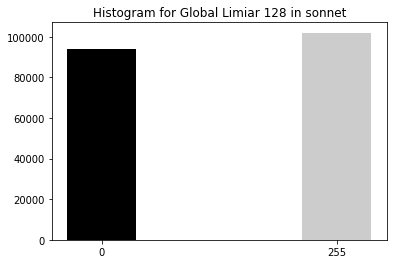

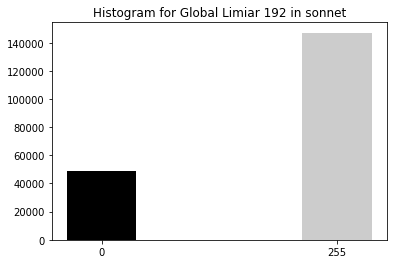

In [19]:
for img in ['monarch', 'peppers', 'sonnet']:
    for threshold in ['64', '128', '192']:
        p = output_images['global_' + threshold + img + '.png']
        p_hist = np.histogram(p, 2)

        fig, ax = plt.subplots()
        plt.bar((p_hist[1][0], p_hist[1][-1]), p_hist[0], width=75.0, color=[(0, 0, 0), (0.8, 0.8, 0.8)])
        plt.xticks((p_hist[1][0], p_hist[1][-1]), ('0', '255'))
        plt.title("Histogram for Global Limiar " + threshold + " in " + img)
        plt.savefig(output_path + 'global_' + threshold + img + '_hist' + '.png')
        plt.show()

### Local Limiarization - Bernsen

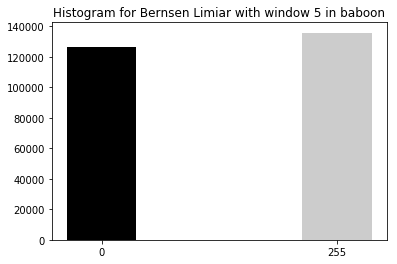

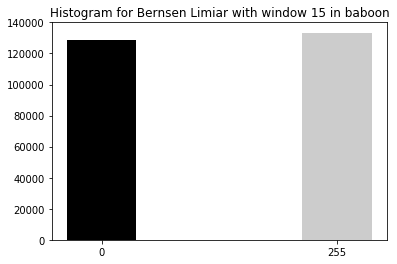

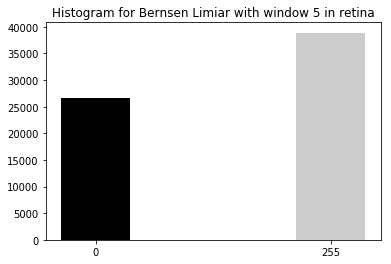

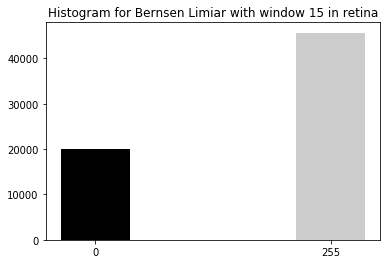

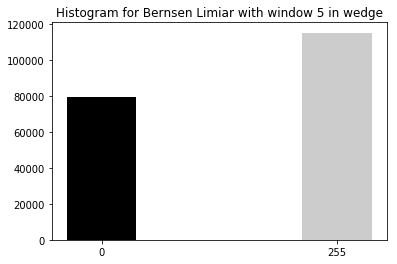

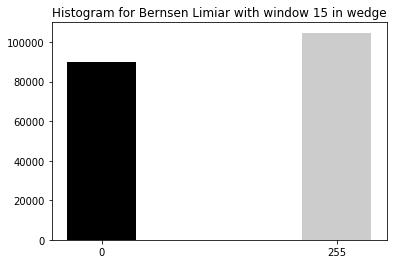

In [21]:
for img in ['baboon', 'retina', 'wedge']:
    for threshold in ['5', '15']:
        p = output_images['bernsen_' + threshold + img + '.png']
        p_hist = np.histogram(p, 2)

        fig, ax = plt.subplots()
        plt.bar((p_hist[1][0], p_hist[1][-1]), p_hist[0], width=75.0, color=[(0, 0, 0), (0.8, 0.8, 0.8)])
        plt.xticks((p_hist[1][0], p_hist[1][-1]), ('0', '255'))
        plt.title("Histogram for Bernsen Limiar with window " + threshold + " in " + img)
        plt.savefig(output_path + 'bernsen_' + threshold + img + '_hist' + '.png')
        plt.show()